In [5]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
from matplotlib.colors import LinearSegmentedColormap
import os
import h5py
import glob
import matplotlib.patches as mpatches
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [6]:
vmax = 1.0
cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, 'tab:pink'),
                                                    (0.3 / vmax, 'tab:pink'),
                                                    (0.30001 / vmax, 'tab:red'),
                                                    (0.55 / vmax, 'tab:red'),
                                                    (0.550001 / vmax, 'tab:orange'),
                                                    (0.85 / vmax, 'tab:orange'),
                                                    (0.850001 / vmax, 'tab:blue'),
                                                    (1 / vmax, 'tab:blue')]
                                        )

green_patch = mpatches.Patch(color='tab:pink', label='1/4 runs')
red_patch = mpatches.Patch(color='tab:red', label='2/4 runs')
yellow_patch = mpatches.Patch(color='tab:orange', label='3/4 runs')
blue_patch = mpatches.Patch(color='tab:blue', label='4/4 runs')

In [7]:
def mtime2datetime(mtime):
    """Convert matlab time to python datetime object
    """
    
    pytime = datetime.datetime.fromordinal(int(mtime) - 366) + datetime.timedelta(days=mtime%1)
    
    return pytime

In [8]:
paths = {
    'drifters': '/ocean/shared/drifters/data/L3/Salish_L3_20190728T103529.mat',
}

drifters = sio.loadmat(paths['drifters'])['drift'][0]

IDs, IDout = list(np.unique(drifters['id'].astype(int))), []
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    if (drifters['lon'][dindex][0] < -125) and (drifters['lat'][dindex][0] < 49): IDout.append(ID)
for ID in IDout: IDs.remove(ID)

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:125: UserWarning: No contour levels were found within the data range.
  [isobath], colors=color, zorder=zorder)


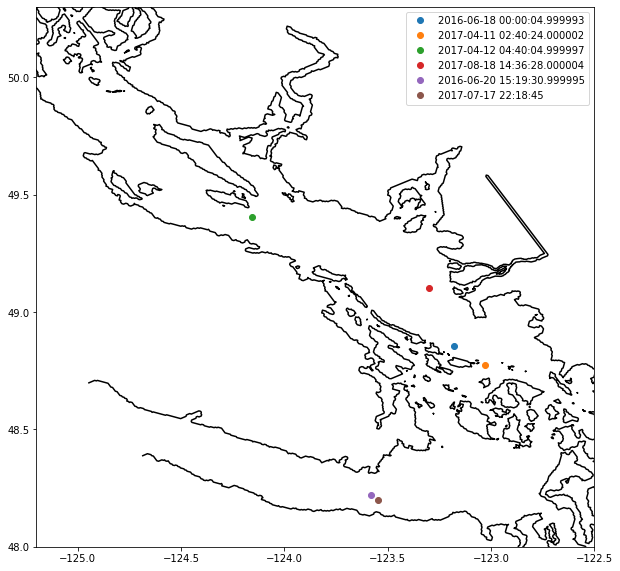

In [9]:
fig, ax = plt.subplots(figsize = (10,10))
for ID in [431, 639, 615, 180, 4341, 662]:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    if ID == 4341:
        ax.plot(drifters['lon'][dindex][10], drifters['lat'][dindex][10], 
            'o', label = mtime2datetime(float(drifters['mtime'][dindex][10])))
    elif ID == 662:
        ax.plot(drifters['lon'][dindex][200], drifters['lat'][dindex][200], 
            'o', label = mtime2datetime(float(drifters['mtime'][dindex][200])))
    else:
        ax.plot(drifters['lon'][dindex][0], drifters['lat'][dindex][0], 
            'o', label = mtime2datetime(float(drifters['mtime'][dindex][0])))
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.legend()
ax.set_ylim(48, 50.3)
ax.set_xlim(-125.2, -122.5)
viz_tools.set_aspect(ax, coords = 'map');

# f0: prob=0.5, limit = 250
# f1: prob = 1, limit = 250
# f2: prob = 0.5, limit = 500
# f3: prob = 1, limit = 500

# Beaching tests

In [12]:
def make_plots(f0,f1,f2,f3, x1lim, y1lim, y2lim, y3lim):
    #print sum of beaching hours
    print('total beaching hours for f0 = ' + str(f0['Beaching_Time'][:,:].sum()))
    print('total beaching hours for f1 = ' + str(f1['Beaching_Time'][:,:].sum()))
    print('total beaching hours for f2 = ' + str(f2['Beaching_Time'][:,:].sum()))
    print('total beaching hours for f3 = ' + str(f3['Beaching_Time'][:,:].sum()))
    
    #make probability arrays
    f0lessthanone = f0['Beaching_Time'][:,:]
    f0lessthanone[(f0lessthanone <= 24) & (f0lessthanone > 0)] = 1
    f0lessthanone[(f0lessthanone > 24) | (f0lessthanone == 0)] = 0

    f1lessthanone = f1['Beaching_Time'][:,:]
    f1lessthanone[(f1lessthanone <= 24) & (f1lessthanone > 0)] = 1
    f1lessthanone[(f1lessthanone > 24) | (f1lessthanone == 0)] = 0

    f2lessthanone = f2['Beaching_Time'][:,:]
    f2lessthanone[(f2lessthanone <= 24) & (f2lessthanone > 0)] = 1
    f2lessthanone[(f2lessthanone > 24) | (f2lessthanone == 0)] = 0

    f3lessthanone = f3['Beaching_Time'][:,:]
    f3lessthanone[(f3lessthanone <= 24) & (f3lessthanone > 0)] = 1
    f3lessthanone[(f3lessthanone > 24) | (f3lessthanone == 0)] = 0

    problessthanone = (f0lessthanone+f1lessthanone+f2lessthanone+f3lessthanone)/4

    f0lessthanthree = f0['Beaching_Time'][:,:]
    f0lessthanthree[(f0lessthanthree <= 72) & (f0lessthanthree > 0)] = 1
    f0lessthanthree[(f0lessthanthree > 72) | (f0lessthanthree == 0)] = 0

    f1lessthanthree = f1['Beaching_Time'][:,:]
    f1lessthanthree[(f1lessthanthree <= 72) & (f1lessthanthree > 0)] = 1
    f1lessthanthree[(f1lessthanthree > 72) | (f1lessthanthree == 0)] = 0

    f2lessthanthree = f2['Beaching_Time'][:,:]
    f2lessthanthree[(f2lessthanthree <= 72) & (f2lessthanthree > 0)] = 1
    f2lessthanthree[(f2lessthanthree > 72) | (f2lessthanthree == 0)] = 0

    f3lessthanthree = f3['Beaching_Time'][:,:]
    f3lessthanthree[(f3lessthanthree <= 72) & (f3lessthanthree > 0)] = 1
    f3lessthanthree[(f3lessthanthree > 72) | (f3lessthanthree == 0)] = 0

    problessthanthree = (f0lessthanthree+f1lessthanthree+f2lessthanthree+f3lessthanthree)/4

    f0lessthanseven = f0['Beaching_Time'][:,:]
    f0lessthanseven[(f0lessthanseven <= 168) & (f0lessthanseven > 0)] = 1
    f0lessthanseven[(f0lessthanseven > 168) | (f0lessthanseven == 0)] = 0

    f1lessthanseven = f1['Beaching_Time'][:,:]
    f1lessthanseven[(f1lessthanseven <= 168) & (f1lessthanseven > 0)] = 1
    f1lessthanseven[(f1lessthanseven > 168) | (f1lessthanseven == 0)] = 0

    f2lessthanseven = f2['Beaching_Time'][:,:]
    f2lessthanseven[(f2lessthanseven <= 168) & (f2lessthanseven > 0)] = 1
    f2lessthanseven[(f2lessthanseven > 168) | (f2lessthanseven == 0)] = 0

    f3lessthanseven = f3['Beaching_Time'][:,:]
    f3lessthanseven[(f3lessthanseven <= 168) & (f3lessthanseven > 0)] = 1
    f3lessthanseven[(f3lessthanseven > 168) | (f3lessthanseven == 0)] = 0

    problessthanseven = (f0lessthanseven+f1lessthanseven+f2lessthanseven+f3lessthanseven)/4
    
    fig, ax = plt.subplots(1,3, figsize = (20,20))

    for a in ax:
        a.pcolormesh(bathy.mask[1:-1, 1:-1], cmap = 'Pastel2')
    
    ax[0].pcolormesh(np.ma.masked_equal(problessthanone,0), vmin = 0, vmax = 1, cmap = cmap)
    ax[1].pcolormesh(np.ma.masked_equal(problessthanthree,0), vmin = 0, vmax = 1, cmap = cmap)
    ax[2].pcolormesh(np.ma.masked_equal(problessthanseven,0), vmin = 0, vmax = 1, cmap = cmap)

    ax[0].set_title('< 1 day')
    ax[1].set_title('< 3 day')
    ax[2].set_title('< 7 day')
    
    plt.legend(handles=[green_patch, red_patch, yellow_patch, blue_patch], 
           bbox_to_anchor=(1.05, 1), loc='upper left')
    
    for a in ax:
        viz_tools.set_aspect(a)
        a.set_ylim(y1lim);
        a.set_xlim(x1lim);
        
    bins = np.arange(0,8)
    fig, ax = plt.subplots(2,2, figsize = (15,10))
    ax[0,0].set_title("beaching time, prob = 0.5, limit = 250m")
    ax[0,1].set_title("prob = 1, lim = 250m")
    ax[1,0].set_title("beaching time, prob = 0.5, limit = 500m")
    ax[1,1].set_title("prob = 1, lim = 500m")
    ax[0,0].hist(f0['Beaching_Time'][:,:].flatten()[f0['Beaching_Time'][:,:].flatten() !=0]/24, bins=bins)
    ax[0,1].hist(f1['Beaching_Time'][:,:].flatten()[f1['Beaching_Time'][:,:].flatten() !=0]/24, bins=bins)
    ax[1,0].hist(f2['Beaching_Time'][:,:].flatten()[f2['Beaching_Time'][:,:].flatten() !=0]/24, bins=bins)
    ax[1,1].hist(f3['Beaching_Time'][:,:].flatten()[f3['Beaching_Time'][:,:].flatten() !=0]/24, 
                 bins=bins)
    for a in ax.flatten():
        a.set_ylim(0,y2lim)
        a.set_xlabel('days')
        
    fig, ax = plt.subplots(2,2, figsize = (15,10))
    ax[0,0].set_title("beaching time, prob = 0.5, limit = 250m")
    ax[0,1].set_title("prob = 1, lim = 250m")
    ax[1,0].set_title("beaching time, prob = 0.5, limit = 500m")
    ax[1,1].set_title("prob = 1, lim = 500m")
    ax[0,0].hist(f0['Beaching_Time'][:,:].flatten()[f0['Beaching_Time'][:,:].flatten() !=0]/24, 
                 bins=bins, cumulative = True)
    ax[0,1].hist(f1['Beaching_Time'][:,:].flatten()[f1['Beaching_Time'][:,:].flatten() !=0]/24, 
                 bins=bins, cumulative = True)
    ax[1,0].hist(f2['Beaching_Time'][:,:].flatten()[f2['Beaching_Time'][:,:].flatten() !=0]/24, 
                 bins=bins, cumulative = True)
    ax[1,1].hist(f3['Beaching_Time'][:,:].flatten()[f3['Beaching_Time'][:,:].flatten() !=0]/24, 
                 bins=bins, cumulative = True)
    for a in ax.flatten():
        a.set_ylim(0,y3lim)
        a.set_xlabel('days');

# NS2

total beaching hours for f0 = 14140
total beaching hours for f1 = 12222
total beaching hours for f2 = 12082
total beaching hours for f3 = 11201


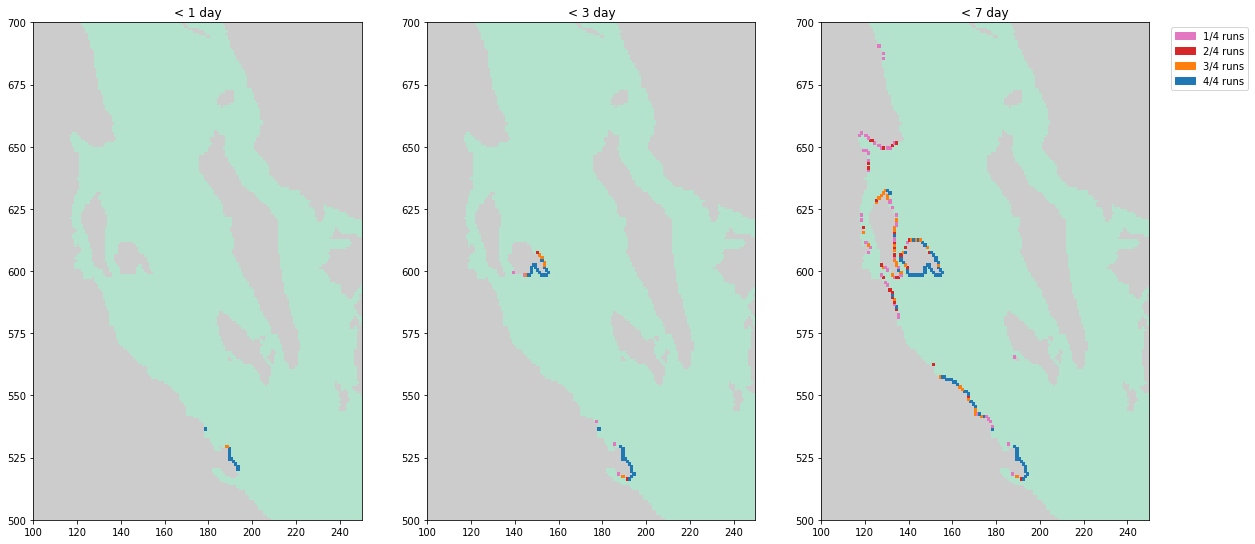

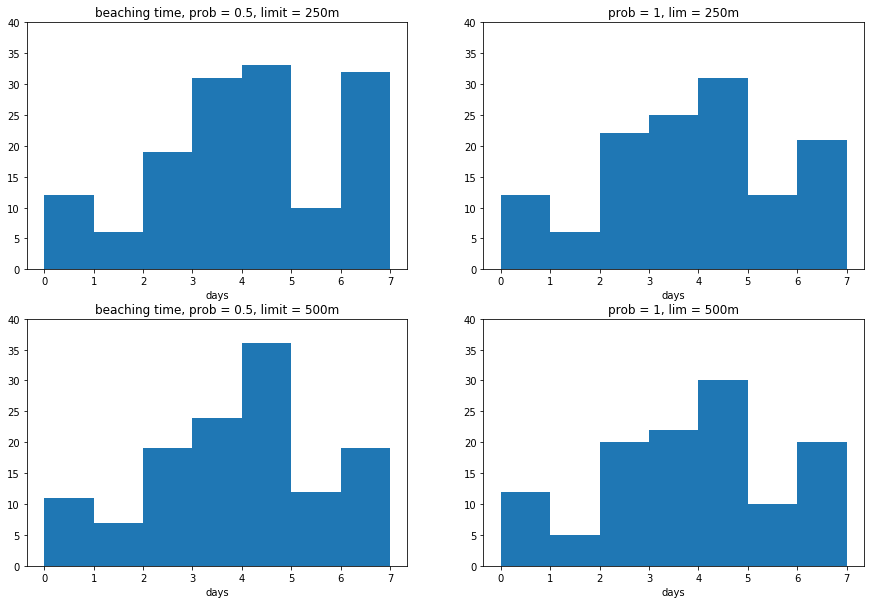

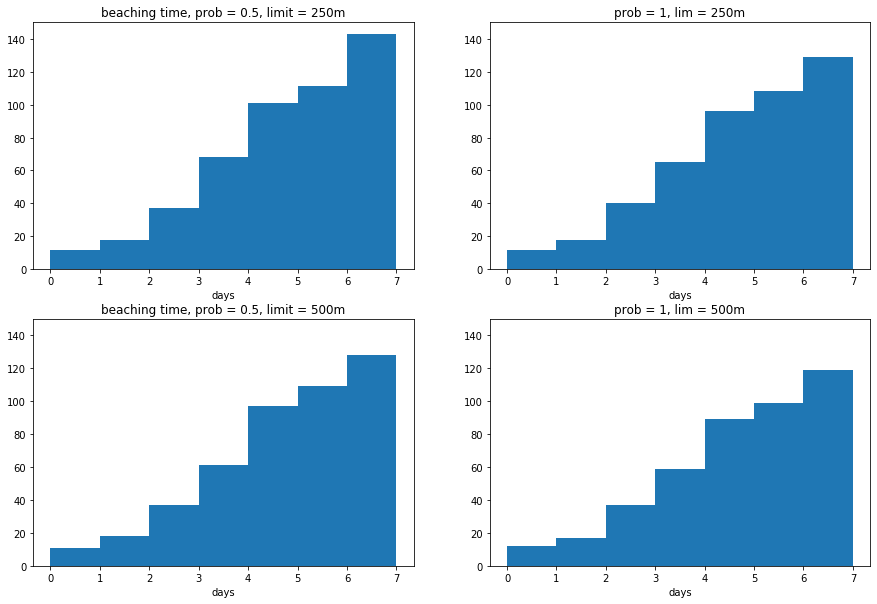

In [13]:
f0 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-0_beachingtestsNS2-0.nc')
f1 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-1_beachingtestsNS2-1.nc')
f2 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-2_beachingtestsNS2-2.nc')
f3 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-3_beachingtestsNS2-3.nc')
make_plots(f0, f1, f2, f3, (100,250), (500,700), 40, 150)

# HS1

total beaching hours for f0 = 21769
total beaching hours for f1 = 17878
total beaching hours for f2 = 19002
total beaching hours for f3 = 14614


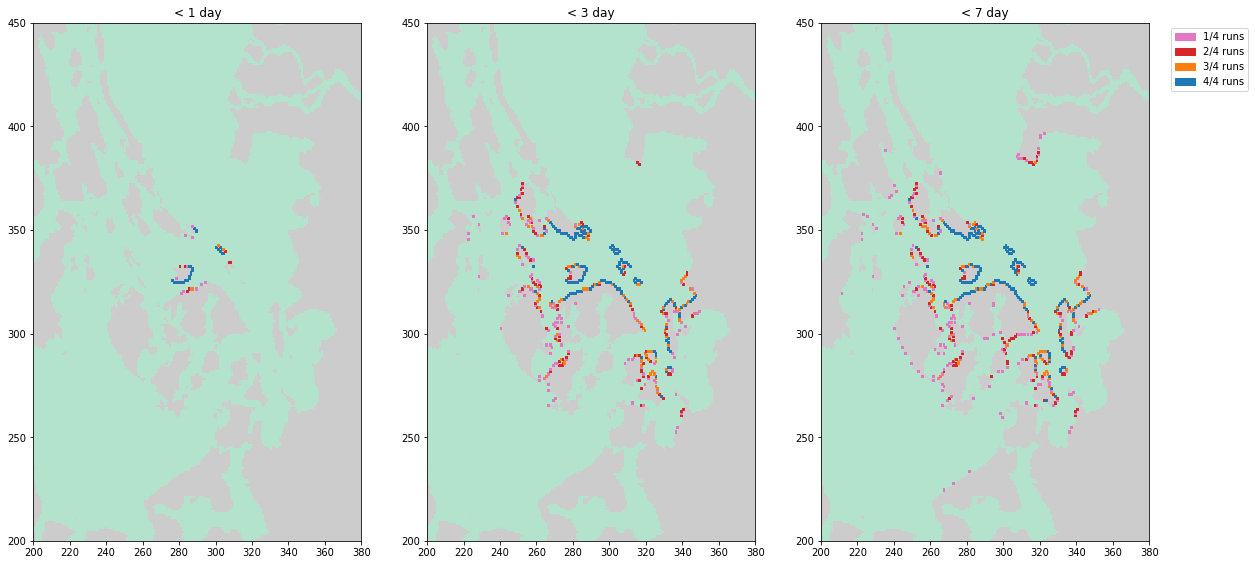

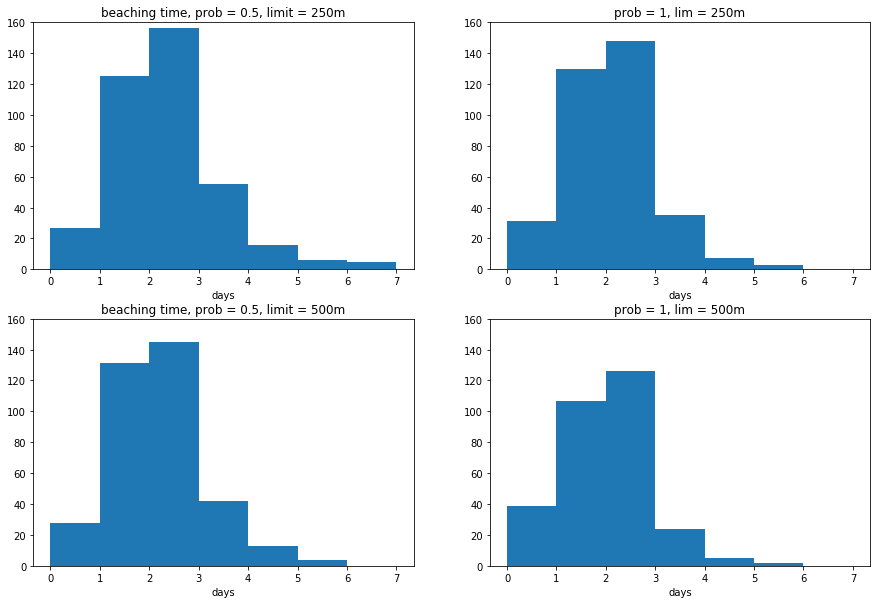

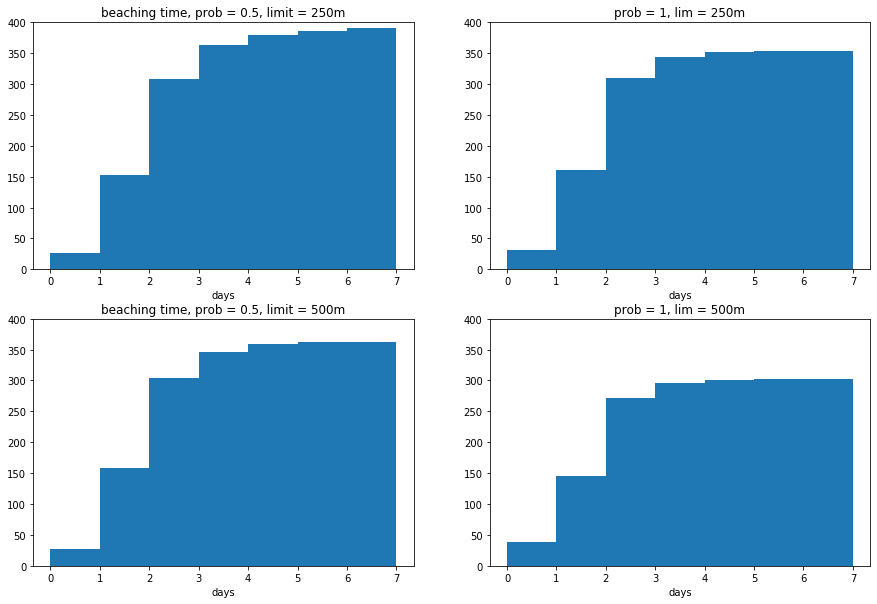

In [14]:
f0 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-0_beachingtestsHS1-0.nc')
f1 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-1_beachingtestsHS1-1.nc')
f2 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-2_beachingtestsHS1-2.nc')
f3 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-3_beachingtestsHS1-3.nc')
make_plots(f0, f1, f2, f3, (200,380), (200,450), 160, 400)

# HS2

total beaching hours for f0 = 6514
total beaching hours for f1 = 2451
total beaching hours for f2 = 2570
total beaching hours for f3 = 1002


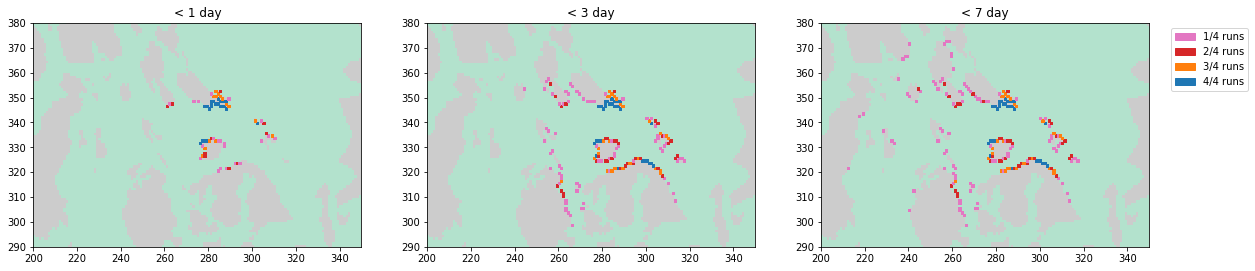

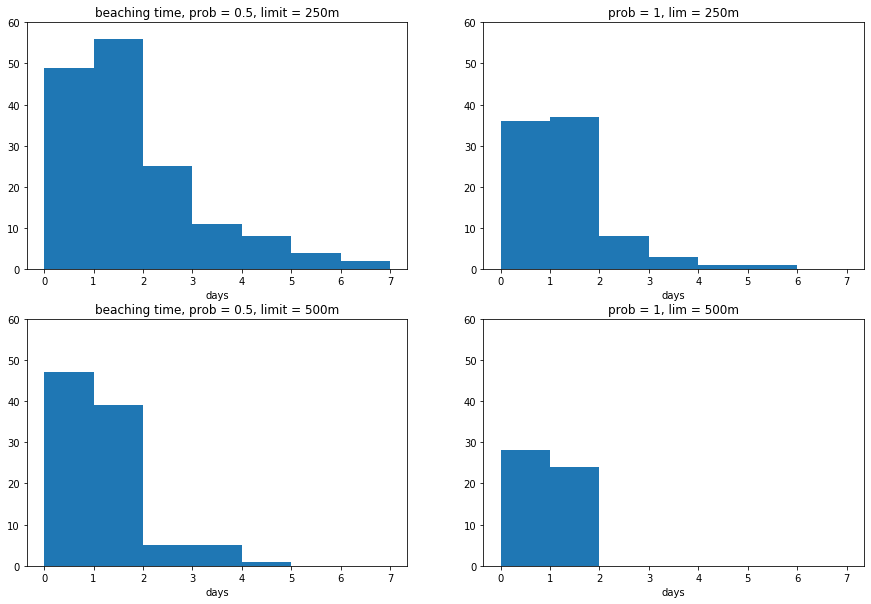

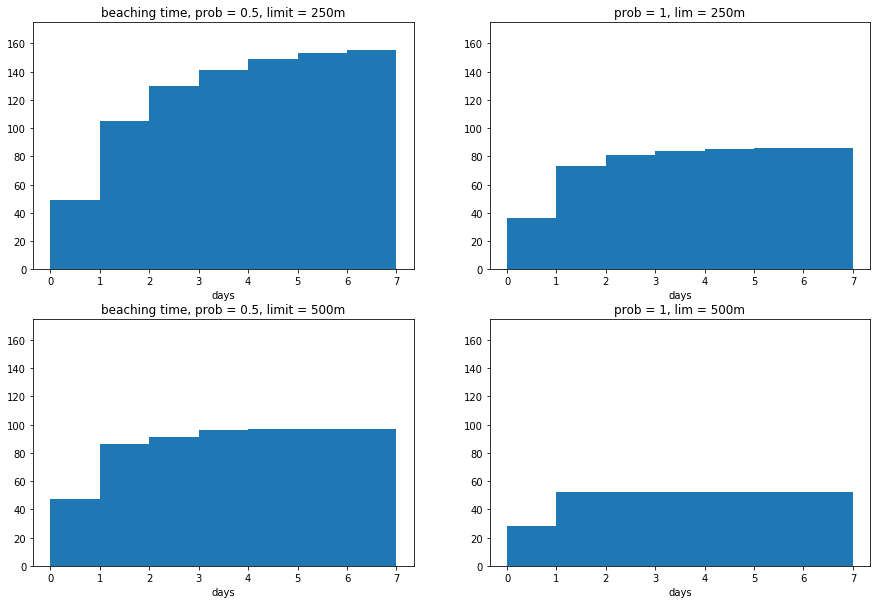

In [15]:
f0 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-0_beachingtestsHS2-0.nc')
f1 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-1_beachingtestsHS2-1.nc')
f2 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-2_beachingtestsHS2-2.nc')
f3 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-3_beachingtestsHS2-3.nc')
make_plots(f0, f1, f2, f3, (200,350), (290,380), 60, 175)

# SH2

total beaching hours for f0 = 5313
total beaching hours for f1 = 2854
total beaching hours for f2 = 2422
total beaching hours for f3 = 1543


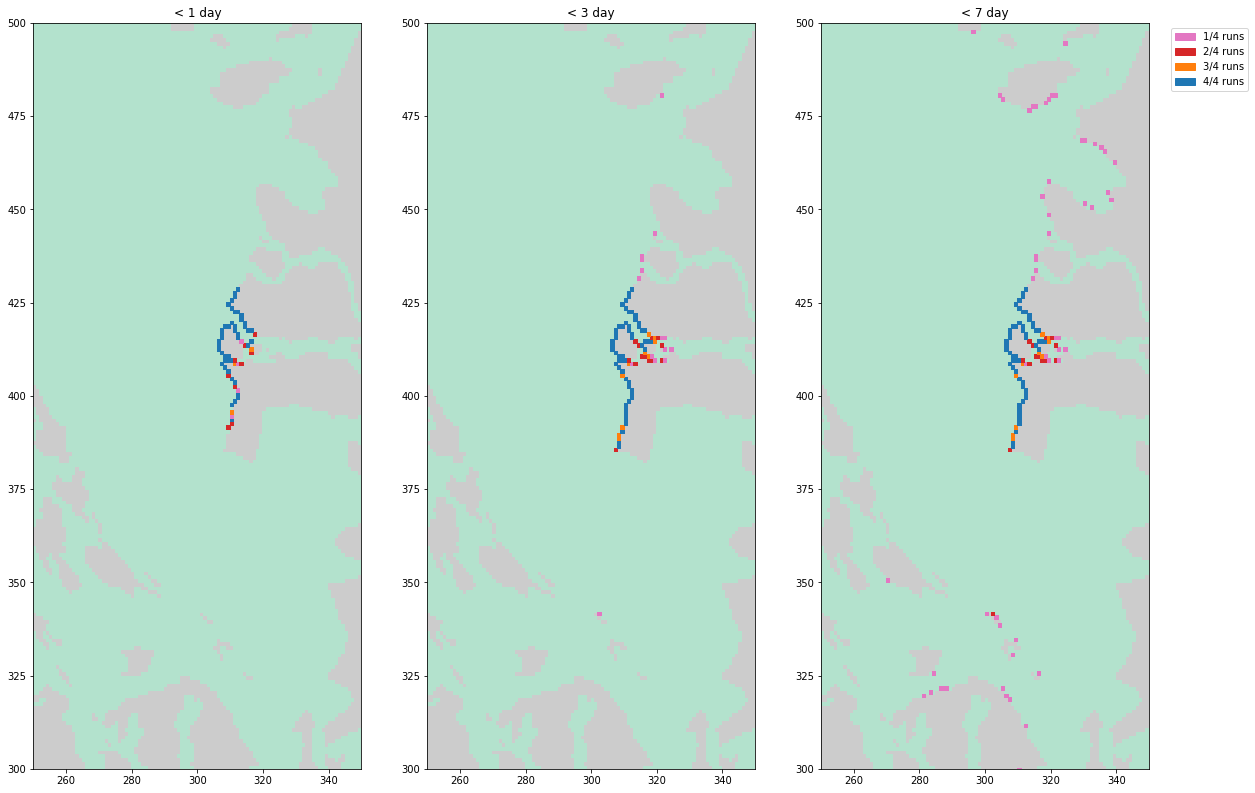

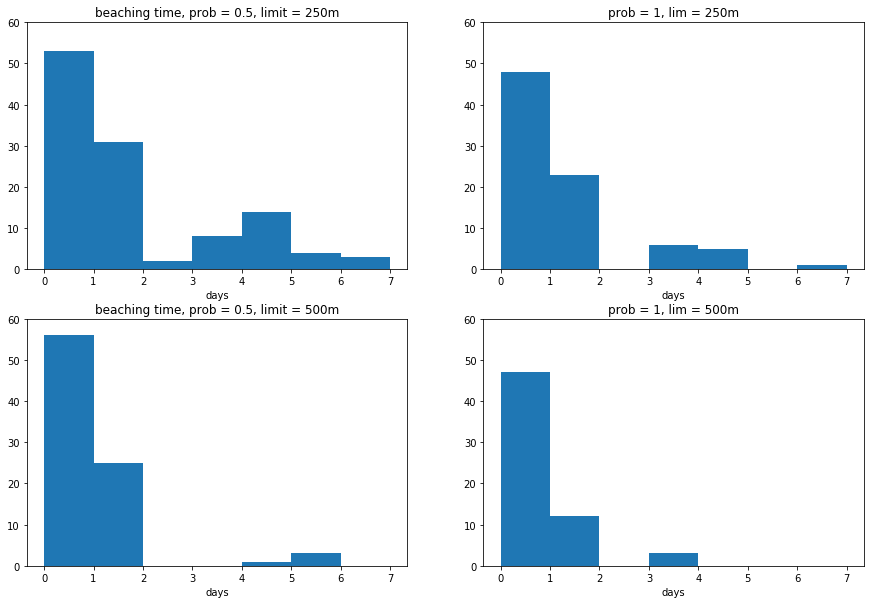

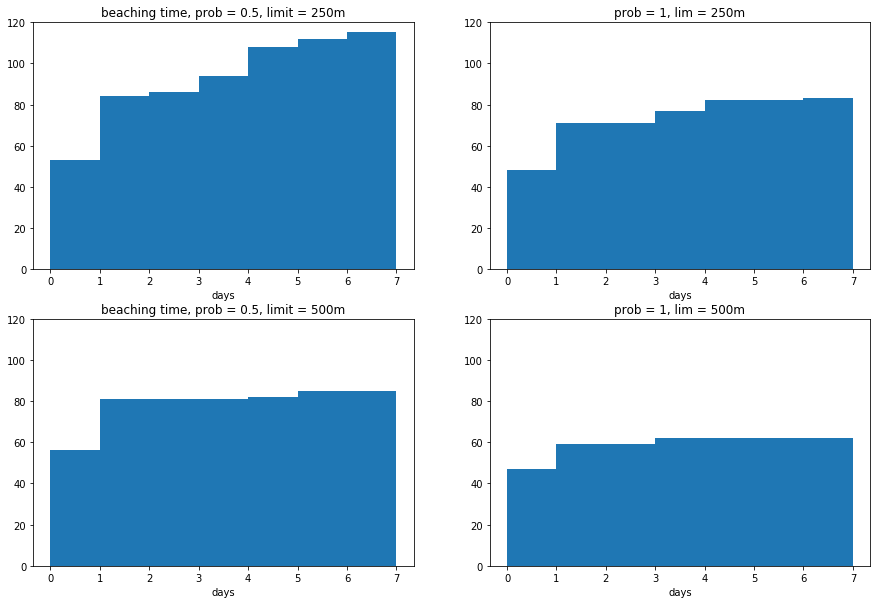

In [16]:
f0 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-0_beachingtestsSH2-0.nc')
f1 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-1_beachingtestsSH2-1.nc')
f2 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-2_beachingtestsSH2-2.nc')
f3 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-3_beachingtestsSH2-3.nc')
make_plots(f0, f1, f2, f3, (250,350), (300,500), 60, 120)

# VS1

total beaching hours for f0 = 14907
total beaching hours for f1 = 13429
total beaching hours for f2 = 12955
total beaching hours for f3 = 11888


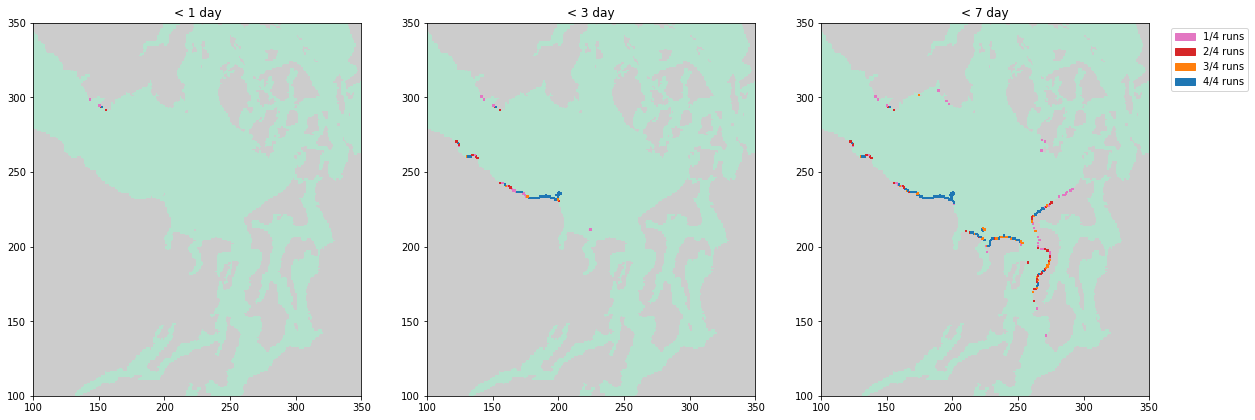

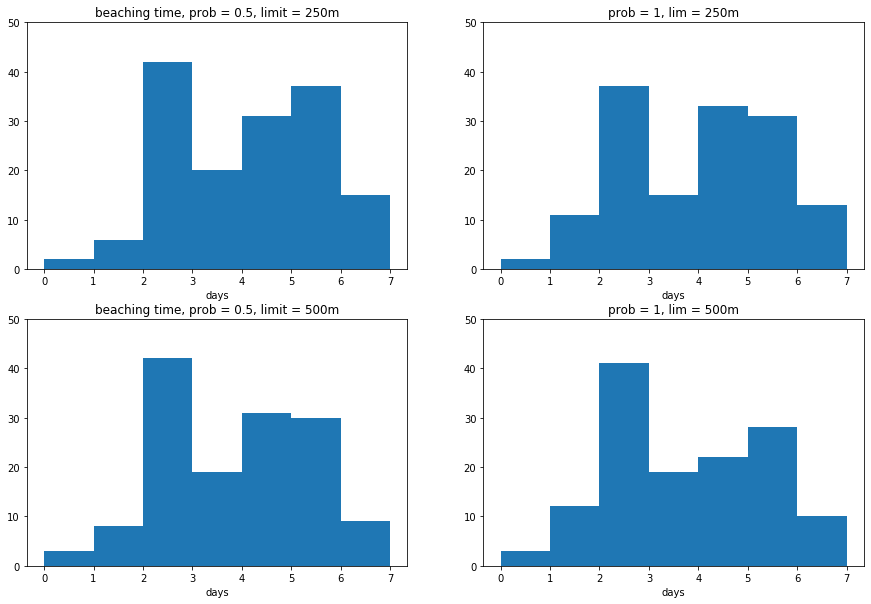

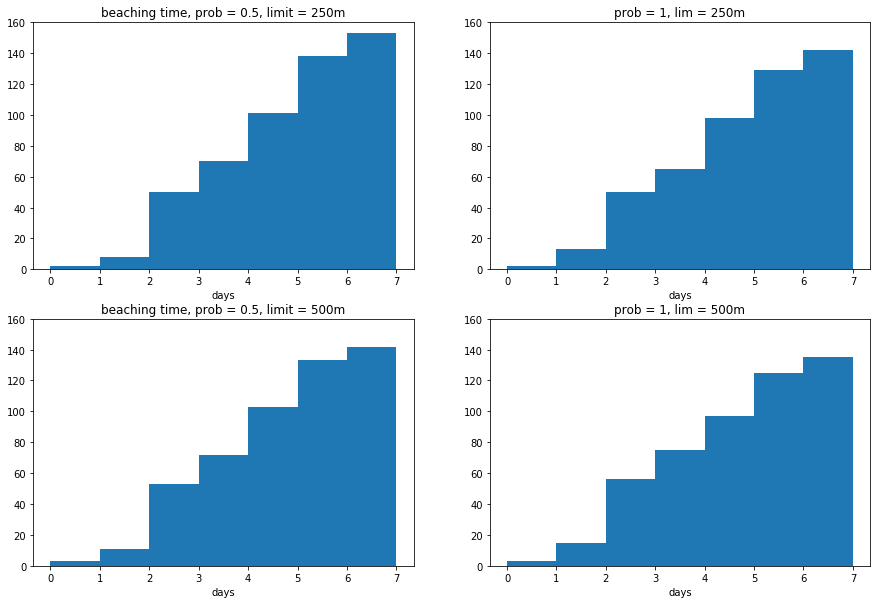

In [17]:
f0 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-0_beachingtestsVS1-0.nc')
f1 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-1_beachingtestsVS1-1.nc')
f2 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-2_beachingtestsVS1-2.nc')
f3 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-3_beachingtestsVS1-3.nc')
make_plots(f0, f1, f2, f3, (100,350), (100,350), 50, 160)

# VS2

total beaching hours for f0 = 10175
total beaching hours for f1 = 11087
total beaching hours for f2 = 11882
total beaching hours for f3 = 10244


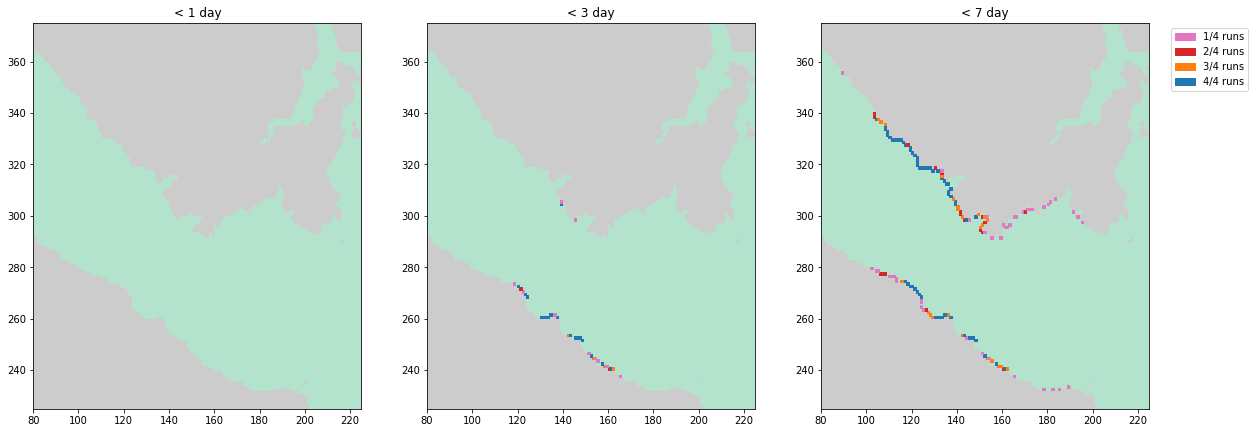

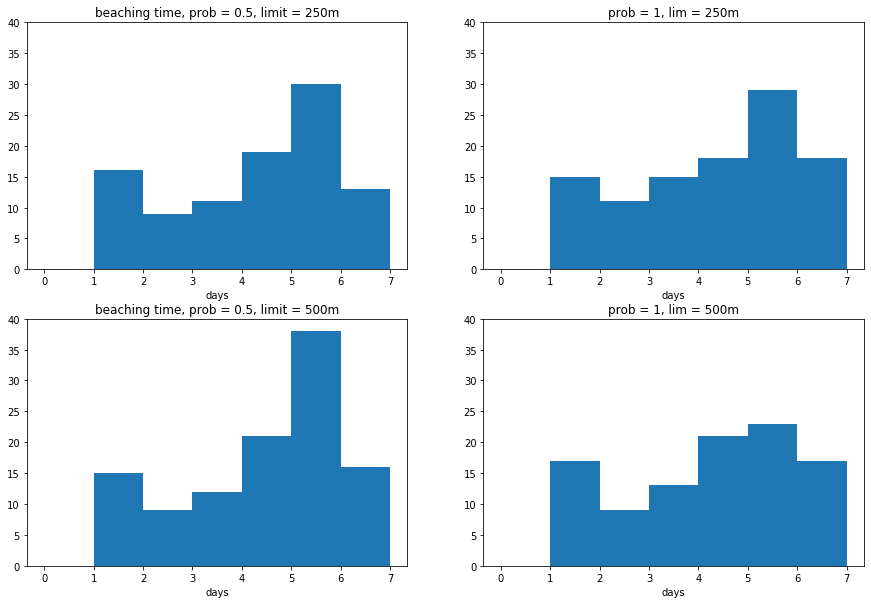

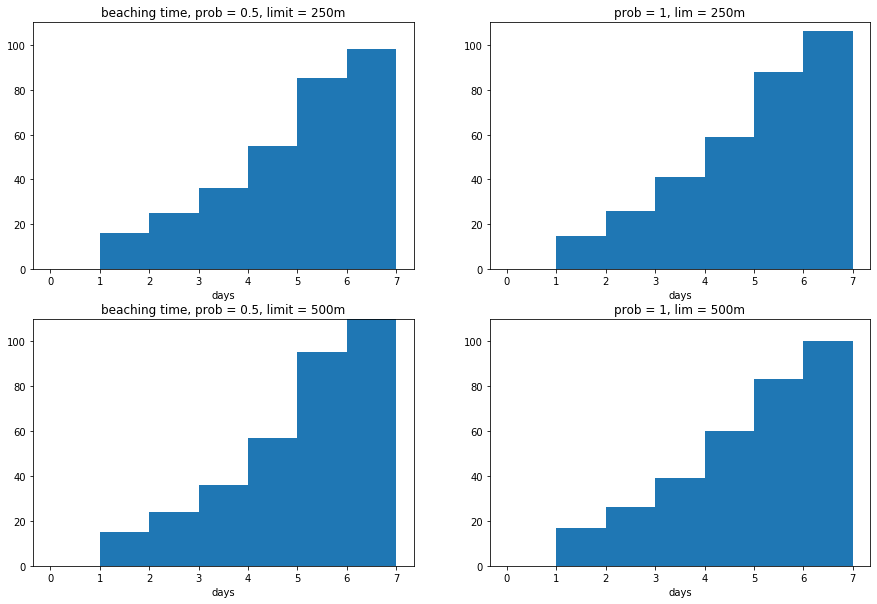

In [18]:
f0 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-0_beachingtestsVS2-0.nc')
f1 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-1_beachingtestsVS2-1.nc')
f2 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-2_beachingtestsVS2-2.nc')
f3 = nc.Dataset('/ocean/vdo/MIDOSS/results/Lagrangian_AKNS_crude-3_beachingtestsVS2-3.nc')
make_plots(f0, f1, f2, f3, (80,225), (225,375), 40, 110)